### podatci sa kaggle

In [159]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('Mall_Customers.csv')




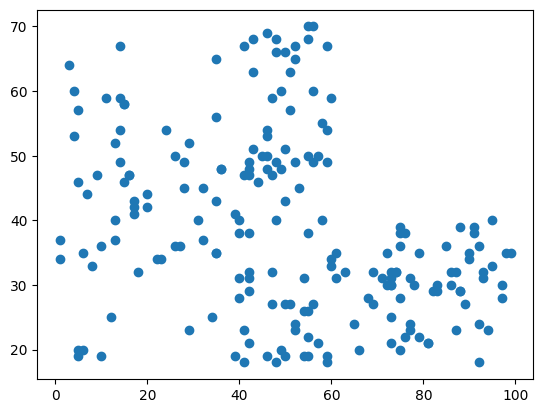

In [160]:
plt.scatter(df.SpendingScore, df.Age)

DBSCAN

In [161]:
from matplotlib.colors import ListedColormap
import numpy as np

In [162]:
def euc_dist(p1,p2):
    return np.sqrt(np.sum(np.square(p1 - p2)))

#matrica koja sadrži sve udaljenosti točaka
def matrix_distances(df, atr1, atr2):
    matrix = []
    for i1, j1 in zip(df[atr1].values, df[atr2].values):
        temp = []
        for i2, j2 in zip(df[atr1].values, df[atr2].values):
            temp.append(euc_dist(np.array([i1, j1]), np.array([i2, j2])))
        matrix.append(temp)
    #print(matrix)
    return matrix
    
# za točku provjeriti cijeli redak i 
def categorize_points(point_index, radius, minBr, matrix):
    points = []
    # jer se ubraja i 0.0. iz matrice
    counter = -1
    #print('point_index', point_index)
    #print(matrix[point_index])
    for i in matrix[point_index]:
        if int(i) <= radius:
            counter += 1
            points.append(i)
    #ako točka ima minimalni broj točaka u radijusu, onda je core point => 1
    if counter >= minBr:
        return 1
    #ako točka nema dovoljno točaka u radijusu, onda je achievable point => 2 -> kasnije provjeravamo koliko ima core points u svojem radijusu u pretvaramo ih u 2 ili 3
    elif counter > 0  and counter < minBr:
        return 2
    #ako nema niti jedne točke u radijusu, onda je noise => 3
    else:
        return 3

    
#inicjalno označavanje točaka
def inital_point_categorized(matrix, radius, minBr):
    #za svaku točku odredim kategoriju
    categories = []
    for i in range(len(matrix)):
        cat = categorize_points(i, radius, minBr, matrix)
        categories.append(cat)
    # za achievable provjerili jesu li achievable ili noise
    
    for c_idx in range(len(categories)):
        checker = False
        if categories[c_idx] == 2:
            for i in range(len(matrix[c_idx])):
                if matrix[c_idx][i] <= radius and categories[i] == 1:
                    checker = True        
            if checker == False:
                categories[c_idx] = 3
                
                
        
    #print(categories)
    return categories


# funkcija
# random odabrana core point (npr. prva neoznačena)-> sve core points u radijusu dodamo u novi cluster
# za svaku novododanu ponoviti
# za sve katergorije 2 koje dodiruju kat.1 dodamo ne šireći
# mislim da se može i automatski, samo ne proširujem
# ponavljam dok ima slobodnih core 
# slobodne gledam kao nedodjeljene niti jednom clusteru
# napravim listu sa 0 gdje su označeni clusteri

def second_categorization(matrix, categories, radius):
    # točke koje ne pripradaju niti jednom clusteru => -1
    clusters = []
    print('-> ',len(matrix))
    for i in matrix:
        clusters.append(-1)
    cluster_counter = 0
    #noise pretvoriti u 0
    for n_idx in range(len(categories)):
       if categories[n_idx] == 3:
           clusters[n_idx] = 0
   
    # random odabrana core point (npr. prva neoznačena)-> sve core points u radijusu dodamo u novi cluster 
    break_term = False
    while break_term == False:
        # odaberem nedodjeljenu core point
        for init_core_index in range(len(categories)):
            # odaberem početnu core point za cluster
            if categories[init_core_index] == 1 and clusters[init_core_index] == -1:
                
                add_points = []
                cluster_counter = cluster_counter + 1
                add_points.append(init_core_index)
                clusters[add_points[0]] = cluster_counter
                while add_points:
                    
                    for point_idx in range(len(matrix[add_points[0]])):
                        clusters[add_points[0]] = cluster_counter
                        if matrix[add_points[0]][point_idx] <= radius and matrix[add_points[0]][point_idx] > 0:
                        # provjeriti da ta točka je core i da nije već označena
                            if clusters[point_idx] == -1 and categories[point_idx] == 1:
                                add_points.append(point_idx)
                            if clusters[point_idx] == -1 and categories[point_idx] == 2:
                                clusters[point_idx] = cluster_counter
                        
                    add_points.pop(0)
            else:
                break_term = True
    # pretvriti sve achievable koji su -1 u 0
                
    for cl_ind in range(len(clusters)):
        if clusters[cl_ind] == -1:
            clusters[cl_ind] = 0
                
                       
    return clusters
                        


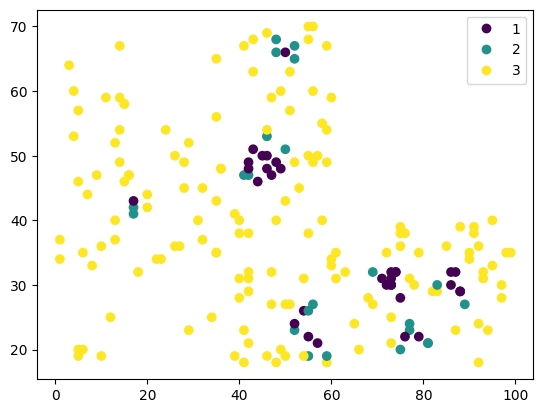

In [163]:

df_2 = df[['Age','SpendingScore','AnnualIncome']]
radius_defined = 3
minBr_defined = 5

inital_categories = inital_point_categorized(matrix_distances(df_2, 'SpendingScore','Age'),
                radius_defined, minBr_defined)

colors = ListedColormap(['#1380a8', '#c4861a', '#851869','#3c90af'])
scatter = plt.scatter(df_2.SpendingScore, df_2.Age, c=inital_categories)

plt.legend(*scatter.legend_elements())
plt.show()


->  200


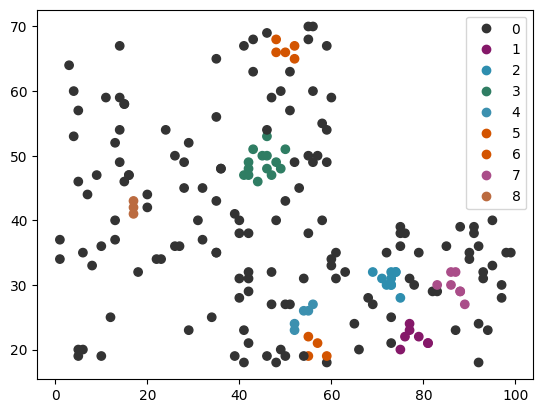

In [164]:
inital_categories = inital_point_categorized(matrix_distances(df_2, 'SpendingScore','Age'),
                radius_defined, minBr_defined)

second_categories = second_categorization(matrix_distances(df_2, 'SpendingScore','Age'),
                inital_categories, radius_defined)


colors = ListedColormap(['#333333',
'#c4861a','#851869','#5d8aa8','#257e5b','#2e8eaf','#c34f55',
'#2f7d63','#9b59b6','#663399','#3c90af','#508c40','#d35400','#3e7ecf','#b25c27','#d35400','#c24e4f','#aa4d89',
'#4f7a9f','#bb6b40'])
scatter = plt.scatter(df_2.SpendingScore, df_2.Age, c=second_categories, cmap=colors)

plt.legend(*scatter.legend_elements())
plt.show()



Agglomerative Hierarchical Clustering

In [165]:
""" 

def single_linkage(matrix, positions,minimum):
    # spajanje redova
    for i in range(len(matrix)):
        # drugi uvjet: poterbno je zadržati 0 na dijagonali
        if matrix[positions[1]][i] < matrix[positions[0]][i] and matrix[positions[1]][i] != 0.0:
            # u vodoravnom smjeru
            matrix[positions[0]][i] = matrix[positions[1]][i]
            # u vertikalnom smjeru
            matrix[i][positions[0]] = matrix[i][positions[1]]
    
    # brisanje 
    # vertikalno
    for i in range(len(matrix)):
        matrix[i].pop(positions[1])
    # horizontalno
    matrix.remove(matrix[positions[1]])
        
    return matrix, positions, minimum

def double_linkage(matrix, positions,minimum):
    # spajanje redova -> POPRAVITI
    for i in range(len(matrix)):
        if matrix[positions[1]][i] > matrix[positions[0]][i]:
            if matrix[positions[0]][i] != 0.0:
                # u vodoravnom smjeru
                matrix[positions[0]][i] = matrix[positions[1]][i]
                # u horizontalnom smjeru
                matrix[i][positions[1]]= matrix[positions[1]][i]
    
    # brisanje 
    # vertikalno
    for i in range(len(matrix)):
        matrix[i].pop(positions[1])
    # horizontalno
    matrix.remove(matrix[positions[1]])
        
    return matrix, positions, minimum

# pronalazak trenutne najmanje udaljenosti u matrici i njene pozicije
def min_value_matrix(matrix, linkage):

    min_dict = {}
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j] != 0.0:  
                min_dict[(i,j)] = matrix[i][j]

    min_current = min(min_dict.values())
    for key, value in min_dict.items():
        if value == min_current:

            key_found = key
            break 
    return linkage(matrix, key_found,min_current)    
    

def flatten(lst):
    flattened_list = []
    for item in lst:
        if isinstance(item, list):
            flattened_list.extend(flatten(item))
        else:
            flattened_list.append(item)
    return flattened_list

def matrix_minimization(matrix, linkage):
    clusters_dict = {}   # novi cluster: min,max
    matrix_mod = matrix
    borders = []
    for i in range(len(matrix)):
        borders.append(i)
    for _ in range(len(matrix) -1):
        # pozovem smanjenje tablice i tip 
        matrix_mod, positions, minimum = min_value_matrix(matrix_mod, linkage)

        #maknem positions[1] u borders, dodam positions[0]
        # nekad su brojevi, nekad su liste
        if type(borders[positions[0]]) == list:
            for i in borders[positions[0]]:
                if type(i) == list:
                    borders[positions[0]] = flatten(borders[positions[0]])
        if type(borders[positions[1]]) == list:
            for i in borders[positions[1]]:
                if type(i) == list:
                    borders[positions[1]] = flatten(borders[positions[1]])    
                         
        borders[positions[0]] =flatten([borders[positions[0]],borders[positions[1]]])
        
        borders.pop(positions[1])
        
        # problem nastaje kada imam više istih minimalnih vrijednosti
        # onda se vrijednosti samo prepisuju
        # za svaki min napraviti novi cluster
        if minimum not in clusters_dict.keys():
            clusters_dict[minimum] = borders[positions[0]]

        
        
    
    return clusters_dict


def normalize(categories):
    counter = 1
    mapping = {}
    for i in range(len(categories)):
        if categories[i] != 0 and categories[i] not in mapping:
            mapping[categories[i]] = counter
            categories[i] = counter
            counter += 1
        elif categories[i] != 0 and categories[i] in mapping:
            categories[i] = mapping[categories[i]]
    return categories
            

def final_clusters(n,diagram,break_point):
    # u početku imam sve clustere
    clusters_final = []
    for i in range(n):
        clusters_final.append(0)
    # pronađem gdje mi je break point u diagram_dictionary
    clusters_up_to_now = []
    for key in diagram.keys():
        if key < break_point:
            clusters_up_to_now.append(diagram[key])
        if key > break_point:
            break
    
    # pokušaj br 2: nema micanja, nego samo prepišem
    cluster_counter = 0
    for cl in clusters_up_to_now:
        cluster_counter += 1
        for c in cl:
            clusters_final[c] = cluster_counter
    
    return normalize(clusters_final)
     """

' \n\ndef single_linkage(matrix, positions,minimum):\n    # spajanje redova\n    for i in range(len(matrix)):\n        # drugi uvjet: poterbno je zadržati 0 na dijagonali\n        if matrix[positions[1]][i] < matrix[positions[0]][i] and matrix[positions[1]][i] != 0.0:\n            # u vodoravnom smjeru\n            matrix[positions[0]][i] = matrix[positions[1]][i]\n            # u vertikalnom smjeru\n            matrix[i][positions[0]] = matrix[i][positions[1]]\n    \n    # brisanje \n    # vertikalno\n    for i in range(len(matrix)):\n        matrix[i].pop(positions[1])\n    # horizontalno\n    matrix.remove(matrix[positions[1]])\n        \n    return matrix, positions, minimum\n\ndef double_linkage(matrix, positions,minimum):\n    # spajanje redova -> POPRAVITI\n    for i in range(len(matrix)):\n        if matrix[positions[1]][i] > matrix[positions[0]][i]:\n            if matrix[positions[0]][i] != 0.0:\n                # u vodoravnom smjeru\n                matrix[positions[0]][i] =

In [166]:

def single_linkage(matrix, positions,minimum):
    # spajanje redova
    for i in range(len(matrix)):
        # drugi uvjet: poterbno je zadržati 0 na dijagonali
        if matrix[positions[1]][i] < matrix[positions[0]][i] and matrix[positions[1]][i] != 0.0:
            # u vodoravnom smjeru
            matrix[positions[0]][i] = matrix[positions[1]][i]
            # u vertikalnom smjeru
            matrix[i][positions[0]] = matrix[i][positions[1]]
    
    # brisanje 
    # vertikalno
    for i in range(len(matrix)):
        matrix[i].pop(positions[1])
    # horizontalno
    matrix.remove(matrix[positions[1]])
        
    return matrix, positions, minimum

def double_linkage(matrix, positions,minimum):
    # spajanje redova -> POPRAVITI
    for i in range(len(matrix)):
        if matrix[positions[1]][i] > matrix[positions[0]][i]:
            if matrix[positions[0]][i] != 0.0:
                # u vodoravnom smjeru
                matrix[positions[0]][i] = matrix[positions[1]][i]
                # u horizontalnom smjeru
                matrix[i][positions[1]]= matrix[positions[1]][i]
    
    # brisanje 
    # vertikalno
    for i in range(len(matrix)):
        matrix[i].pop(positions[1])
    # horizontalno
    matrix.remove(matrix[positions[1]])
        
    return matrix, positions, minimum

# pronalazak trenutne najmanje udaljenosti u matrici i njene pozicije
def min_value_matrix(matrix, linkage):

    min_dict = {}
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j] != 0.0:  
                min_dict[(i,j)] = matrix[i][j]

    min_current = min(min_dict.values())
    for key, value in min_dict.items():
        if value == min_current:

            key_found = key
            break 
    return linkage(matrix, key_found,min_current)    
    

def flatten(lst):
    flattened_list = []
    for item in lst:
        if isinstance(item, list):
            flattened_list.extend(flatten(item))
        else:
            flattened_list.append(item)
    return flattened_list

def matrix_minimization(matrix, linkage):
    clusters = []
    minimums = []
    matrix_mod = matrix
    borders = []
    for i in range(len(matrix)):
        borders.append(i)
    for _ in range(len(matrix) -1):
        # pozovem smanjenje tablice i tip 
        matrix_mod, positions, minimum = min_value_matrix(matrix_mod, linkage)

        #maknem positions[1] u borders, dodam positions[0]
        # nekad su brojevi, nekad su liste
        if type(borders[positions[0]]) == list:
            for i in borders[positions[0]]:
                if type(i) == list:
                    borders[positions[0]] = flatten(borders[positions[0]])
        if type(borders[positions[1]]) == list:
            for i in borders[positions[1]]:
                if type(i) == list:
                    borders[positions[1]] = flatten(borders[positions[1]])    
                         
        borders[positions[0]] =flatten([borders[positions[0]],borders[positions[1]]])
        
        borders.pop(positions[1])
        
        # problem nastaje kada imam više istih minimalnih vrijednosti
        # onda se vrijednosti samo prepisuju
        # za svaki min napraviti novi cluster
        clusters.append(borders[positions[0]])
        minimums.append(minimum)


        
        
    
    return clusters, minimums


def normalize(categories):
    counter = 1
    mapping = {}
    for i in range(len(categories)):
        if categories[i] != 0 and categories[i] not in mapping:
            mapping[categories[i]] = counter
            categories[i] = counter
            counter += 1
        elif categories[i] != 0 and categories[i] in mapping:
            categories[i] = mapping[categories[i]]
    return categories
            

def final_clusters(n,clusters,minimums,break_point):
    # u početku imam sve clustere
    clusters_final = []
    for i in range(n):
        clusters_final.append(0)
    # pronađem gdje mi je break point u diagram_dictionary
    clusters_up_to_now = []
    for idx in range(len(minimums)):
        if minimums[idx] <= break_point:
            clusters_up_to_now.append(clusters[idx])
        if minimums[idx]  > break_point:
            break
    
    # pokušaj br 2: nema micanja, nego samo prepišem
    cluster_counter = 0
    for cl in clusters_up_to_now:
        cluster_counter += 1
        for c in cl:
            clusters_final[c] = cluster_counter
    
    return normalize(clusters_final)


[[3, 5], [2, 6], [0, 4], [2, 6, 8], [1, 3, 5], [1, 3, 5, 9], [1, 3, 5, 9, 7], [0, 4, 1, 3, 5, 9, 7], [0, 4, 1, 3, 5, 9, 7, 2, 6, 8]]
[1.4142135623730951, 2.0, 2.23606797749979, 3.1622776601683795, 4.123105625617661, 4.47213595499958, 13.341664064126334, 32.0624390837628, 33.015148038438355]
[1, 2, 3, 2, 1, 2, 3, 0, 3, 2]
3 5 1.4142135623730951 2
2 6 2.0 2
0 4 2.23606797749979 2
8 11 3.1622776601683795 3
1 10 4.123105625617661 3
9 14 4.47213595499958 4
7 15 13.341664064126334 5
12 16 32.0624390837628 7
13 17 33.015148038438355 10


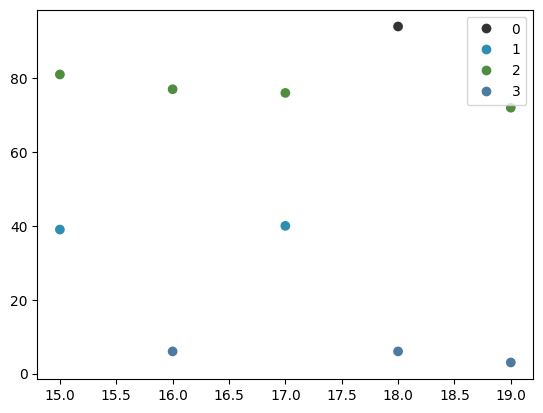

In [167]:
def dendogram(clusters, minimums):
    dendrogram_data = []
    clusters_up_to_now = []
    for idx in range(len(clusters)):
        
        temp = []
        # dva nova indexa
        if len(clusters[idx]) == 2:
            temp.append(clusters[idx][0])
            temp.append(clusters[idx][1])
            
            clusters_up_to_now.append(clusters[idx])
            
        # nisu samo indexi clustera, nego liste
        else:
           # prvi subset
            subset_found = False
            for sublist in clusters_up_to_now:
                if (set(sublist).issubset(set(clusters[idx]))):
                    subset_found = True
                    subset = sublist
                    clusters_up_to_now.remove(sublist)
                    clusters_up_to_now.append(clusters[idx])
                    break
            
            # drugi subset
            subset_found2 = False
            for sublist2 in clusters_up_to_now:
                if (set(sublist2).issubset(set(clusters[idx]))) and sublist2 != clusters[idx]:
                    subset_found2 = True
                    subset2 = sublist2
                    clusters_up_to_now.remove(sublist2)
                    clusters_up_to_now.append(clusters[idx])
                    break

            if subset_found2 == True:
                position = clusters.index(subset) + len(minimums) +1
                position2 = clusters.index(subset2) + len(minimums)  +1
                temp.append(position)
                temp.append(position2)
                
            elif subset_found == True:
                new_elements = next(iter(set(clusters[idx]) - set(subset)))
                position = clusters.index(subset) + len(minimums) +1
                temp.append(min(new_elements, position))
                temp.append(max(new_elements, position))


        temp.append(minimums[idx])
        temp.append(len(clusters[idx]))
        
        dendrogram_data.append(temp)

    return dendrogram_data


#----------------------------------------------------------------
colors = ListedColormap(['#333333',
    '#c4861a','#bb6b40','#851869','#5d8aa8','#257e5b','#2e8eaf','#c34f55',
    '#2f7d63','#9b59b6','#663399','#3c90af','#aa4d89','#508c40','#d35400','#3e7ecf','#b25c27','#d35400','#c24e4f',
    '#4f7a9f'])
break_point = 8
df_2 = df_2.head(10)
matrix_ah = matrix_distances(df_2, 'AnnualIncome','SpendingScore')
n = len(matrix_ah)
clusters_ah = {}
clusters,minimums = matrix_minimization(matrix_ah,single_linkage)
print(clusters)
print(minimums)
# crtanje dendograma
dendrogram_data = dendogram(clusters, minimums)

final_cl = final_clusters(n,clusters,minimums,break_point)
print(final_cl)
#problem -> imam više clustera iste vrijednosti
def print_2d_list(matrix):
    for row in matrix:
        print(' '.join(map(str, row)))
print_2d_list(dendrogram_data)

scatter = plt.scatter(df_2.AnnualIncome, df_2.SpendingScore, c=final_cl, cmap=colors)

plt.legend(*scatter.legend_elements())
plt.show()

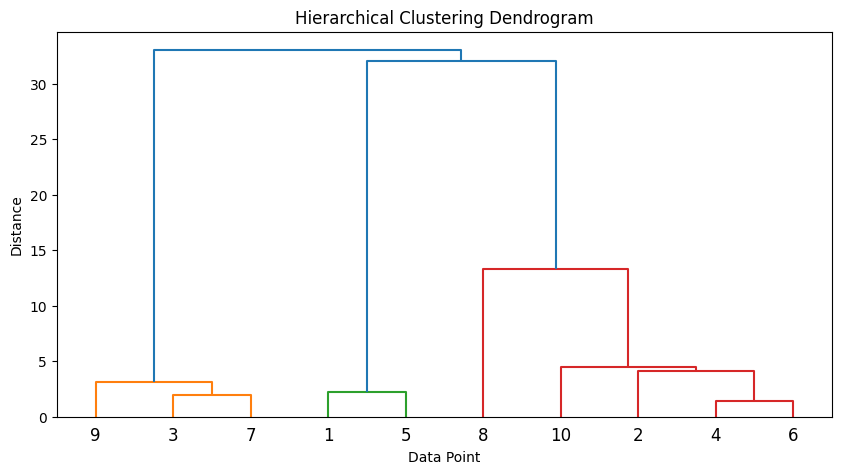

In [168]:
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Point')
plt.ylabel('Distance')
dendrogram(dendrogram_data, labels=np.arange(1, len(df_2) + 1))
plt.show()

[[ 3.          5.          1.41421356  2.        ]
 [ 2.          6.          2.          2.        ]
 [ 0.          4.          2.23606798  2.        ]
 [ 8.         11.          3.16227766  3.        ]
 [ 1.         10.          4.12310563  3.        ]
 [ 9.         14.          4.47213595  4.        ]
 [ 7.         15.         13.34166406  5.        ]
 [12.         16.         32.06243908  7.        ]
 [13.         17.         33.01514804 10.        ]]


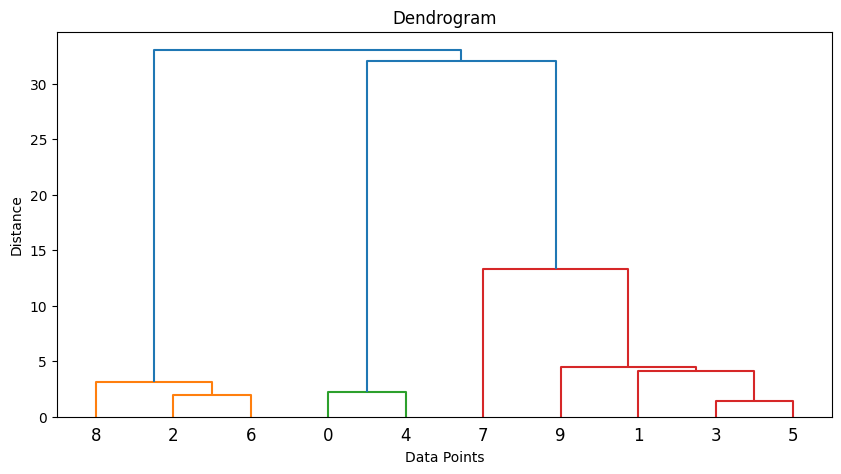

In [169]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

selected_attributes = df_2[['AnnualIncome', 'SpendingScore']]

# Compute linkage
Z = linkage(selected_attributes, method='single')

# Plot dendrogram
plt.figure(figsize=(10, 5))
print(Z)
dendrogram(Z)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.show()